In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Introduction

Topic identification is a task of NLP (natural language processing). In this project, our task is to assign a unque label to each paper title. Given the raw dataset is not one title to one label, we first applied data cleaning and data categorizaton to the dataset. Then did supervised training by using LSTM, BERT, CNN and a self-created model.

# Data Source

Data Source: 
- paper: https://link.springer.com/chapter/10.1007/978-3-031-02444-3_19
- github: https://github.com/1pha/paperswithtopic

# Data loading and preprocessing

Prepare cleaned and normalized data for bert, lstm and cnn.
- version 1 (first try):
  - Load csv file data into dataframe
  - Cutting some label types
  - Lowercase to Uppercase by using regex
  - Remove punctuation marks by using regex
  - Remove stopwords by using regex
  - Match each paper topic to one label only
- version 2 (second try):
  - remove the paper title which has multiple labels
  - the amount of data of each topic is not balanced, so we choose 600 records for each topic


## load data

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

#### data preprocessing and topic sentence file version1

In [3]:
df = pd.read_csv("drive/MyDrive/paperswithtopic.csv",encoding="utf-8")

df1 = df.loc[:, 'adversarial':'time-series'].idxmax(axis=1)
df['result'] = df1

result_df_v1 = df[["Unnamed: 0", "result"]].rename({"Unnamed: 0": "topic"}, axis=1)

#### data preprocessing verison2
Originally, we compare the values of all the labels of each topic sentences and select the biggest one as the true label, it turned out the model does not perform very well. In the version2 data process, we analyze the raw data and find that most of topic sentences only has one label, so in the code below, we delete all the samples which have more than one label to make the data reasonable.

In [4]:
df = pd.read_csv("drive/MyDrive/paperswithtopic.csv",encoding="utf-8")
df_labels = df.loc[:, 'adversarial':'time-series']
arr = list(map(set,df_labels.values))
def remove(_):
  _.remove(0)
  return _
result = list(map(remove, arr))

Counter([len(_) for _ in result])

Counter({1: 44359, 2: 5203, 3: 395, 4: 22, 6: 1})

In [5]:
df['label_number'] = [len(_) for _ in result]
df = df[df['label_number'].values == 1]

In [6]:
# only select data which has one label
df['label_number']

0        1
3        1
5        1
6        1
7        1
        ..
49975    1
49976    1
49977    1
49978    1
49979    1
Name: label_number, Length: 44359, dtype: int64

#### topic sentences file version2
create the dataframe which contains topic sentences 

In [7]:
df1 = df.loc[:, 'adversarial':'time-series'].idxmax(axis=1)
df['result'] = df1
df = df.drop(['label_number'], axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [8]:
result_df_v2 = df[["Unnamed: 0", "result"]].rename({"Unnamed: 0": "topic"}, axis=1)

## clean data

### normalize data


In [9]:
def normalise_text (text):
    text = text.str.lower() # lowercase
    text = text.str.replace(r":","") # replace :
    text = text.str.replace(r"\"","") # remove ""
    text.str.replace(r"\(.*\)","") # remove anything inside ()
    text = text.str.replace(r"[^A-Za-z0-9()!?\'\`]", " ")
    return text

### remove stop words

In [10]:
# Setup
!pip install -q wordcloud
import wordcloud

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [11]:
stop_words = set(stopwords.words('english'))
def remove_stop_words (line):
  word_tokens = word_tokenize(line)
  words = [_ for _ in word_tokens if _ and _ not in stop_words]
  return " ".join(words)

### clean data 

In [12]:
result_df_v1['topic'] = normalise_text(result_df_v1["topic"])
result_df_v1['topic'] = result_df_v1['topic'].apply(lambda line: remove_stop_words(line))

result_df_v2['topic'] = normalise_text(result_df_v2["topic"])
result_df_v2['topic'] = result_df_v2['topic'].apply(lambda line: remove_stop_words(line))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  


### topic length analysis

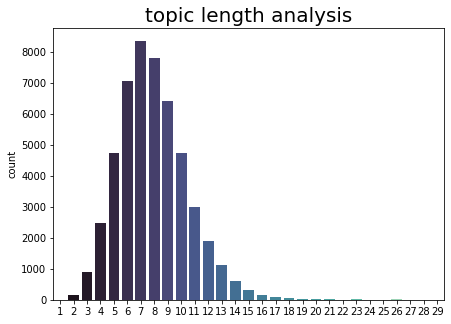

45


In [13]:

text_len = []
for text in result_df_v1.topic:
    topic_len = len(text.split())
    text_len.append(topic_len)

result_df_v1['text_len'] = text_len

plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=result_df_v1[result_df_v1['text_len']<30], palette='mako')
plt.title('topic length analysis', fontsize=20)
plt.ylabel('count')
plt.xlabel('')
plt.show()
print(max(text_len))

### dataset categorize

#### generate result_df

dataframes, which are commented out below, are removed after investigating the dataset

In [14]:
def generate_df(result_df):

    df_adversarial = result_df[result_df['result'] == "adversarial" ][['topic']]
    df_adversarial['label'] = 0

    # df_audio = result_df[result_df['result'] == "audio" ][['topic']]
    # df_audio['label'] = 1

    df_computer_code = result_df[result_df['result'] == "computer-code" ][['topic']]
    df_computer_code['label'] = 1

    df_computer_vision = result_df[result_df['result'] == "computer-vision" ][['topic']]
    df_computer_vision['label'] = 2

    df_graphs = result_df[result_df['result'] == "graphs" ][['topic']]
    df_graphs['label'] = 3

    df_knowledge_base = result_df[result_df['result'] == "knowledge-base" ][['topic']]
    df_knowledge_base['label'] = 4

    # df_medical = result_df[result_df['result'] == "medical" ][['topic']]
    # df_medical['label'] = 6

    # df_methodology = result_df[result_df['result'] == "methodology" ][['topic']]
    # df_methodology['label'] = 5

    df_miscellaneous = result_df[result_df['result'] == "miscellaneous" ][['topic']]
    df_miscellaneous['label'] = 5

    # df_music = result_df[result_df['result'] == "music" ][['topic']]
    # df_music['label'] = 9

    df_nlp = result_df[result_df['result'] == "natural-language-processing" ][['topic']]
    df_nlp['label'] = 6

    df_playing_games = result_df[result_df['result'] == "playing-games" ][['topic']]
    df_playing_games['label'] = 7

    # df_reasoning = result_df[result_df['result'] == "reasoning" ][['topic']]
    # df_reasoning['label'] = 8

    df_robots = result_df[result_df['result'] == "robots" ][['topic']]
    df_robots['label'] = 8

    df_speech = result_df[result_df['result'] == "speech" ][['topic']]
    df_speech['label'] = 9

    # df_time_series = result_df[result_df['result'] == "time-series" ][['topic']]
    # df_time_series['label'] = 10

    return df_adversarial,df_computer_code,df_computer_vision,df_graphs,df_knowledge_base,df_miscellaneous,df_nlp,df_playing_games,df_robots,df_speech

#### implement func and print shape

In [15]:
df_adversarial,df_computer_code,df_computer_vision,df_graphs,df_knowledge_base,df_miscellaneous,df_nlp,df_playing_games,df_robots,df_speech = generate_df(result_df_v1)

df_adversarial2,df_computer_code2,df_computer_vision2,df_graphs2,df_knowledge_base2,df_miscellaneous2,df_nlp2,df_playing_games2,df_robots2,df_speech2 = generate_df(result_df_v2)

print(df_adversarial.shape, df_adversarial2.shape)
print(df_computer_code.shape, df_computer_code.shape)
print(df_computer_vision.shape, df_computer_vision.shape)
print(df_graphs.shape, df_graphs.shape)
print(df_knowledge_base.shape, df_knowledge_base.shape)
# print(df_methodology.shape)
print(df_miscellaneous.shape, df_miscellaneous.shape)
print(df_nlp.shape, df_nlp.shape)
print(df_playing_games.shape, df_playing_games.shape)
# print(df_reasoning.shape)
print(df_robots.shape, df_robots.shape)
print(df_speech.shape, df_speech.shape)
# print(df_time_series.shape)

(813, 2) (767, 2)
(1301, 2) (1301, 2)
(3467, 2) (3467, 2)
(3457, 2) (3457, 2)
(830, 2) (830, 2)
(1593, 2) (1593, 2)
(8450, 2) (8450, 2)
(1353, 2) (1353, 2)
(1516, 2) (1516, 2)
(3209, 2) (3209, 2)


### preparing data & data2
merge all the selected dataframes

In [16]:
# records number
num = 600

data = pd.concat([
    df_adversarial[:num],
    df_computer_code[:num],
    df_computer_vision[:num],
    df_graphs[:num],
    df_knowledge_base[:num],
    df_miscellaneous[:num],
    df_nlp[:num],
    df_playing_games[:num],
    df_robots[:num],
    df_speech[:num]
    ],axis=0).reset_index(drop=True)

data2 = pd.concat([
    df_adversarial2[:num],
    df_computer_code2[:num],
    df_computer_vision2[:num],
    df_graphs2[:num],
    df_knowledge_base2[:num],
    df_miscellaneous2[:num],
    df_nlp2[:num],
    df_playing_games2[:num],
    df_robots2[:num],
    df_speech2[:num]
    ],axis=0).reset_index(drop=True)  

# Use GPU train

In [80]:
#用GPU训练
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla P100-PCIE-16GB


# define metrics

- `plot_cm` is for visualing the confusion matrix. 
- `get_eval` is for evaluation based on the predicted labels and the true labels that we saved in the txt files.
- reference:
  - https://www.kaggle.com/code/agungor2/various-confusion-matrix-plots/notebook

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_cm(y_true, y_pred, figsize=(10,10)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax) 

In [19]:
def get_eval(res_file):
    with open(res_file,"r",encoding="utf-8") as f:
        label_true, label_score,label_pre=[],[],[]
        f=f.readlines()
        data1=[i.split("\n")[0].split(" ") for i in f ]
        
        for line in data1:
            label_true.append(int(line[0]))
            label_score.append(float(line[1]))
            label_pre.append(int(line[2]))
            
    import sklearn.metrics as sm
    rep = sm.classification_report(label_true, label_pre)
    print('classification report：', rep, sep='\n')  

    plot_cm(label_true, label_pre)

# Bert 

## Data preprocessing for bert

### BertTokenizer

using BertTokenizer from transformer package
 - difference of encode() and encode_plus()
    - encode()
      - converts a string in n sequence of ids(integer), using the tokenizer and vocabulary.
      - Same as doing self.convert_tokens_to_ids(self.tokenize(text)).
      - reference: https://huggingface.co/docs/transformers/main_classes/tokenizer#transformers.PreTrainedTokenizer.encode
    - encode_plus()
      - returns a dictionary containing the encoded sequence or sequence pair
      - additional information: the mask for sequence classification and the overflowing elements if a max_length is specified. 
      - reference: https://huggingface.co/docs/transformers/main_classes/tokenizer#transformers.PreTrainedTokenizer.encode_plus

In [34]:
from transformers import BertTokenizer as BertTokenizer

In [35]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

### split dataset func
We use 20% of the whole dataset as test dataset and 80% as train dataset. Then we split the train dataset into train and valid dataset by 90%,10%.

In [20]:
def split_dataset(data):
    ## x is value
    x = data.topic.values
    ## y is label
    y = data.label.values

    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=1)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=1)

    ## add_special_tokens (bool, optional, defaults to True) 
    MAX_LEN = max([len(tokenizer.encode(_, add_special_tokens=True)) for _ in x])

    return X_train, X_valid, X_test, y_train, y_valid, y_test, MAX_LEN

### preprocessing_for_bert function
define a function to get input_ids and attention_masks based on the data we create above.

In [21]:
def preprocessing_for_bert(data, max_length):
  input_ids = []
  attention_masks = []

  for item in data:
    encoded_sent = tokenizer.encode_plus(
        text=item,
        add_special_tokens=True,  ## add [CLS] and [SEP]
        max_length=max_length,  # truncate or padding
        padding='max_length', 
        return_attention_mask=True  # return attention mask
    )

    input_ids.append(encoded_sent.get('input_ids'))
    attention_masks.append(encoded_sent.get('attention_mask'))

  input_ids = torch.tensor(input_ids)
  attention_masks = torch.tensor(attention_masks)
  
  return input_ids, attention_masks

### get the dataloader of the model

In [23]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
# Select a batch size for training. 
# For fine-tuning 16 or 32
batch_size = 32

# create Dataloader for train dataset and validation dataset
def get_dataloader(data):
    
    X_train, X_valid, X_test, y_train, y_valid, y_test, MAX_LEN = split_dataset(data)

    y_train = torch.tensor(y_train)
    y_valid = torch.tensor(y_valid)
    y_test = torch.tensor(y_test)

    train_inputs, train_masks = preprocessing_for_bert(X_train, MAX_LEN)
    valid_inputs, valid_masks = preprocessing_for_bert(X_valid, MAX_LEN)
    test_inputs, test_masks = preprocessing_for_bert(X_test, MAX_LEN)

    train_data = TensorDataset(train_inputs, train_masks, y_train)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    valid_data = TensorDataset(valid_inputs, valid_masks, y_valid)
    valid_sampler = SequentialSampler(valid_data)
    valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=batch_size,shuffle=False)

    test_data = TensorDataset(test_inputs, test_masks, y_test)
    test_sampler = SequentialSampler(test_data)
    test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size,shuffle=False)

    return train_dataloader,valid_dataloader,test_dataloader

## Bert modeling

### reference

- BERT-base
  - uses 12 layers of transformers block (stacked encoders)
  - with a hidden size of 768
  - number of self-attention heads as 12
    -  One word can have different meanings in different sentences (context), and self-attention can encode (understand) each word based on context words for the current word.
    - reference: https://towardsdatascience.com/understand-self-attention-in-bert-intuitively-cd480cbff30b
  - has around 110M trainable parameters.

In [25]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 4.1 MB/s 
     |████████████████████████████████| 7.6 MB 77.2 MB/s 
     |████████████████████████████████| 182 kB 99.1 MB/s 


In [26]:
from transformers import BertModel
import torch.nn as nn

- model
 - https://www.kaggle.com/code/ludovicocuoghi/detecting-bullying-tweets-pytorch-lstm-bert#BERT-Classification
 - https://towardsdatascience.com/adding-custom-layers-on-top-of-a-hugging-face-model-f1ccdfc257bd
 - https://discuss.huggingface.co/t/on-using-the-final-cls-hidden-state-of-roberta/15024

### customized bert model
define a customized bert class containing the pre-trained model and fine-tuning.

In [27]:
class customizedBert1(nn.Module):
    def __init__(self, freeze_bert=False ):
        super(customizedBert1, self).__init__()

        D_in, H, D_out = 768, 100, 10

        self.bert = BertModel.from_pretrained('bert-base-uncased')

        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(H, D_out)
        )

        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):

        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # #outputs[0]=last hidden state
        # Extract the last hidden state of the token `[CLS]` for classification task
        # Often the last hidden state of the [CLS] token is used as a feature to train a downstream model on
        last_hidden_state_cls = outputs[0][:, 0, :]

        logits = self.classifier(last_hidden_state_cls)
        return logits

### customized bert model version2
 bert with pooling& normlayer

In [28]:
#### add pooling
class customizedBert2(nn.Module):
    def __init__(self):
        super(customizedBert2, self).__init__()

        D_in, H, D_out = 768, 100, 10

        self.bert = BertModel.from_pretrained('bert-base-uncased')

        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(H, D_out)
        )
        
        self.pooling = 'cls' # 'last-avg', 'cls'
        self.dropout = nn.Dropout(p=0.2)
        self.layer_norm = nn.LayerNorm(768)

        # if freeze_bert:
        #     for param in self.bert.parameters():
        #         param.requires_grad = False

    def forward(self, input_ids, attention_mask):

        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # #outputs[0]=last hidden state
        # Extract the last hidden state of the token `[CLS]` for classification task
        # Often the last hidden state of the [CLS] token is used as a feature to train a downstream model on

        if self.pooling == 'cls':
          out = outputs[0][:, 0, :]
        elif self.pooling == 'last-avg':
          last = outputs[0].transpose(1, 2)  # [batch, 768, seqlen]
          out = torch.avg_pool1d(last, kernel_size=last.shape[-1]).squeeze(-1)  # [batch, 768]
         
        out = self.layer_norm(out)
        out = self.dropout(out)
        out_fc = self.classifier(out)

        return out_fc

### define train_bert function

In [29]:
from tqdm import tqdm
def train_bert(model,device, train_dataloader, valid_dataloader, epochs, loss_fn, save_path):
    model.to(device)
    ### Learning rate (Adam): 5e-5, 3e-5, 2e-5
    optimizer = AdamW(model.parameters(),
                      lr=2e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                    )
    # Total number of training steps is [number of batches] x [number of epochs]
    # (Note that this is not the same as the number of training samples).
    total_steps = len(train_dataloader) * epochs
    # Create the learning rate scheduler.
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)

    #lists to host the train and validation losses of every batch for each epoch
    train_loss, val_loss  = [], []
    #lists to host the train and validation accuracy of every batch for each epoch
    train_acc, val_acc  = [], []
    #lists to host the train and validation predictions of every batch for each epoch
    y_train_list, y_val_list = [], []

    #initalize number of total and correctly classified texts during training and validation
    correct, correct_val = 0, 0
    b_total, b_total_val = 0, 0

    for ep in range(epochs):      
        with tqdm(total=len(train_dataloader), desc=f'Epoch {ep + 1}/{epochs}', unit='it') as pbar:
            for step, batch in enumerate(train_dataloader):
                model.train()
                b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
                b_total += b_labels.size(0)
                model.zero_grad()

                logits = model(b_input_ids, b_attn_mask)
                loss = loss_fn(logits, b_labels)
                train_loss.append(loss.item())
                train_preds = torch.argmax(logits,dim=1).flatten()
                correct += torch.sum(train_preds==b_labels).item()
                train_acc.append(100*correct / b_total)

                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

                optimizer.step()
                scheduler.step()
     
                for step, batch in enumerate(valid_dataloader):

                    with torch.no_grad():

                        model.eval()
                        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
                        
                        logits = model(b_input_ids, b_attn_mask)
                        valid_loss = loss_fn(logits, b_labels.long())

                        val_preds = torch.argmax(logits, dim=1).flatten()
                        correct_val += torch.sum(val_preds==b_labels).item()
                        b_total_val += b_labels.size(0)
            
                        val_loss.append(valid_loss.item())
                        val_acc.append(100*correct_val / b_total_val)
                  
                pbar.set_postfix(train_loss= format(np.mean(train_loss),'.3f'), 
                                train_acc= format(np.mean(train_acc),'.2f')+'%',
                                val_loss= format(np.mean(val_loss),'.3f'), 
                                val_acc= format(np.mean(val_acc),'.2f')+'%'
                                )
                pbar.update(1)

        torch.save(model.state_dict(), save_path)

### initate model

- optmization
   - Schedules:get_linear_schedule_with_warmup
    - Create a schedule with a learning rate that decreases linearly from the initial lr set in the optimizer to 0, after a warmup period during which it increases linearly from 0 to the initial lr set in the optimizer.
   - AdamW
   - https://huggingface.co/docs/transformers/main_classes/optimizer_schedules#transformers.AdamW

In [30]:
from transformers import AdamW, get_linear_schedule_with_warmup

first use lr = 5e-5. not good, training loss is small 0.00441 0.0023, but test loss is stll high, not big improvement on test_accuracy

In [31]:
bertV1 = customizedBert1()
bertV2 = customizedBert2()

loss_fn = nn.CrossEntropyLoss()

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight'

### Training model

In [36]:
train_dataloader, valid_dataloader, test_dataloader = get_dataloader(data)
train_dataloader2, valid_dataloader2, test_dataloader2 = get_dataloader(data2)

In [ ]:
train_bert(bertV1,device, train_dataloader, valid_dataloader, 50, loss_fn,'bertV1_a.pt')

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
Epoch 3/3: 100%|██████████| 135/135 [03:04<00:00,  1.37s/it, train_acc=48.80%, train_loss=1.274, val_acc=51.73%, val_loss=1.228]


In [ ]:
train_bert(bertV1,device, train_dataloader2, valid_dataloader2, 50, loss_fn, 'bertV1_b.pt')

In [ ]:
train_bert(bertV2,device, train_dataloader, valid_dataloader, 50, loss_fn, 'bertV2_a.pt')

In [ ]:
train_bert(bertV2,device, train_dataloader2, valid_dataloader2, 50, loss_fn, 'bertV2_b.pt')

#### define evaluate bert

In [37]:
import torch

def evaluate_bert(model, test_dataloader,save_path, res_file):
    
    m_state_dict = torch.load(save_path)
    model.to(device)
    model.load_state_dict(m_state_dict)
       
    model.eval()
    test_accuracy = []
    test_loss = []
    # consider each batch in the test_dataloader 
    # store the evaluation result
    with open(res_file, "w", encoding="utf-8") as f:
        for batch in test_dataloader:
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
            with torch.no_grad():
                logits = model(b_input_ids, b_attn_mask)
            loss = loss_fn(logits, b_labels.long())
            test_loss.append(loss.item())
            preds = torch.argmax(logits, dim=1).flatten()  

            for idx_max,line in enumerate(logits):
                f.write(str(b_labels[idx_max].item())+" "+str(line[preds[idx_max]].item())+" "+str(preds[idx_max].item())+"\n")
            
            accuracy = (preds == b_labels).cpu().numpy().mean() * 100
            test_accuracy.append(accuracy)

    test_loss = np.mean(test_loss)
    test_accuracy = np.mean(test_accuracy)

    print('test_loss: ', format(test_loss,'.2f'))
    print('test_accuracy: ', format(test_accuracy,'.2f'))

# LSTM


## data processing for LSTM

#### prepare data

In [46]:
# get the maximum length
import pandas as pd
import numpy as np

max_len = len(max(data['topic'], key=len))
print(max_len) #151

188


In [47]:
from collections import Counter

def Tokenize(column, seq_len):
  ##Create vocabulary of words from column
  corpus = [word for text in column for word in text.split()]
  count_words = Counter(corpus)
  sorted_words = count_words.most_common()
  # sort it by the frequncet of word for highest to lowest

  # vocabulary to int
  # example: {'learning': 1, 'graph': 2, 'adversarial': 3 ...
  vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}


  ## text -> int
  text_int = []
  for text in column:
    r = [vocab_to_int[word] for word in text.split()]
    text_int.append(r)

  
  ## add padding to tokens
  # all zero matrix 
  features = np.zeros((len(text_int), seq_len), dtype = int)

  for i, review in enumerate(text_int):
    if len(review) <= seq_len:
        if len(review) <= seq_len:
            zeros = list(np.zeros(seq_len - len(review)))
            new = zeros + review
        else:
            new = review[: seq_len]
        features[i, :] = np.array(new)

  return sorted_words, features

## pre padding
vocabulary, tokenized_column = Tokenize(data['topic'], max_len)


In [48]:
## collect all words from topic set
Word2vec_train_data = list(map(lambda x: x.split(), data['topic']))

In [49]:
## set a dimension of the embedding words,
## as in the number of features of each transformed word
EMBEDDING_DIM = 200

In [50]:
## instaniate the Word2Vec model by passing the training words
## and chosen embedding dimension to the improved Word2Vec object
from gensim.models import Word2Vec
word2vec_model = Word2Vec(Word2vec_train_data, size=EMBEDDING_DIM, window=5, min_count=1, workers=4)

In [51]:
## we also need to choose the max number of words.
## We will extract the number of words 
## from the vocabulary python dictionary we created before.
VOCAB_SIZE = len(vocabulary) + 1 #+1 for the padding

In [52]:
#define empty embedding matrix
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))
    
#fill the embedding matrix with the pre trained values from word2vec
#corresponding to word (string), token (number associated to the word)
for word, token in vocabulary:
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (6187, 200)


#### create dataset

In [53]:
## x is value
x = tokenized_column
## y is label
y = data.label.values

In [54]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=1)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=1)

In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [56]:
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
valid_data = TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(y_valid))

In [57]:
BATCH_SIZE = 32

In [58]:
train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True) 
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)

## LSTM modeling

- https://www.kaggle.com/code/nazmultakbir/nlp-with-pytorch-glove-lstm-ensembling

#### lstm v1

In [59]:
class LSTM_V1(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, lstm_layers, bidirectional,batch_size, dropout):
        super(LSTM_V1,self).__init__()
        
        self.lstm_layers = lstm_layers
        self.num_directions = 2 if bidirectional else 1
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes
        self.batch_size = batch_size
        

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            num_layers=lstm_layers,
                            dropout=dropout,
                            bidirectional=bidirectional,
                            batch_first=True)

        self.fc = nn.Linear(hidden_dim*self.num_directions, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x, hidden):
        self.batch_size = x.size(0)
        ##EMBEDDING LAYER
        embedded = self.embedding(x)
        #LSTM LAYERS
        out, hidden = self.lstm(embedded, hidden)
        #Extract only the hidden state from the last LSTM cell
        out = out[:,-1,:]
        #FULLY CONNECTED LAYERS
        out = self.fc(out)
        out = self.softmax(out)

        return out, hidden

    def init_hidden(self, batch_size):
        #Initialization of the LSTM hidden and cell states
        h0 = torch.zeros((self.lstm_layers*self.num_directions, batch_size, self.hidden_dim)).detach().to(DEVICE)
        c0 = torch.zeros((self.lstm_layers*self.num_directions, batch_size, self.hidden_dim)).detach().to(DEVICE)
        hidden = (h0, c0)
        return hidden

#### lstm v2

In [60]:
class LSTM_V2(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, lstm_layers, bidirectional,batch_size, dropout):
        super(LSTM_V2,self).__init__()
        
        self.lstm_layers = lstm_layers
        self.num_directions = 2 if bidirectional else 1
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes
        self.batch_size = batch_size
        

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            num_layers=lstm_layers,
                            dropout=dropout,
                            bidirectional=bidirectional,
                            batch_first=True)
        self.pooling = 'cls' # 'last-avg', 'cls'
        self.dropout = nn.Dropout(p=0.2)
        self.layer_norm = nn.LayerNorm(200)

        self.fc = nn.Linear(hidden_dim*self.num_directions, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x, hidden):
        self.batch_size = x.size(0)
        ##EMBEDDING LAYER
        embedded = self.embedding(x)
        #LSTM LAYERS
        out, hidden = self.lstm(embedded, hidden)
        #Extract only the hidden state from the last LSTM cell
        out = out[:,-1,:]
        #FULLY CONNECTED LAYERS
        out = self.layer_norm(out)
        out = self.dropout(out)
        out = self.fc(out)
        out = self.softmax(out)

        return out, hidden

    def init_hidden(self, batch_size):
        #Initialization of the LSTM hidden and cell states
        h0 = torch.zeros((self.lstm_layers*self.num_directions, batch_size, self.hidden_dim)).detach().to(DEVICE)
        c0 = torch.zeros((self.lstm_layers*self.num_directions, batch_size, self.hidden_dim)).detach().to(DEVICE)
        hidden = (h0, c0)
        return hidden

#### initiate model

In [61]:
NUM_CLASSES = 10 #We are dealing with a multiclass classification of 10 classes
HIDDEN_DIM = 100 #number of neurons of the internal state (internal neural network in the LSTM)
LSTM_LAYERS = 1 #Number of stacked LSTM layers

# LR = 3e-4 #Learning rate
LR = 3e-3 # make LR bigger
DROPOUT = 0.2 #LSTM Dropout
BIDIRECTIONAL = True #Boolean value to choose if to use a bidirectional LSTM or not
EPOCHS = 15 #Number of training epoch

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [62]:
LSTM_V1 = LSTM_V1(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM,NUM_CLASSES, LSTM_LAYERS,BIDIRECTIONAL, BATCH_SIZE, DROPOUT)
LSTM_V1 = LSTM_V1.to(DEVICE)

#Initialize embedding with the previously defined embedding matrix
LSTM_V1.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
#Allow the embedding matrix to be fined tuned to better adapt to out dataset and get higher accuracy
LSTM_V1.embedding.weight.requires_grad=True

print(LSTM_V1)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


LSTM_V1(
  (embedding): Embedding(6187, 200)
  (lstm): LSTM(200, 100, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=200, out_features=10, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [63]:
LSTM_V2 = LSTM_V2(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM,NUM_CLASSES, LSTM_LAYERS,BIDIRECTIONAL, BATCH_SIZE, DROPOUT)
LSTM_V2 = LSTM_V2.to(DEVICE)

#Initialize embedding with the previously defined embedding matrix
LSTM_V2.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
#Allow the embedding matrix to be fined tuned to better adapt to out dataset and get higher accuracy
LSTM_V2.embedding.weight.requires_grad=True

print(LSTM_V2)

LSTM_V2(
  (embedding): Embedding(6187, 200)
  (lstm): LSTM(200, 100, batch_first=True, dropout=0.2, bidirectional=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (layer_norm): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
  (fc): Linear(in_features=200, out_features=10, bias=True)
  (softmax): LogSoftmax(dim=1)
)


#### define train_lstm

In [64]:
from tqdm import tqdm
def train_lstm(model,device, train_loader, valid_loader, EPOCHS, save_path):
    criterion = nn.NLLLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay = 5e-6)

    train_loss, valid_loss  = [], []
    train_acc, valid_acc  = [], []

    correct, correct_val = 0, 0
    total, total_val = 0, 0

    early_stopping_patience = 4
    early_stopping_counter = 0
    valid_acc_max = 0

    for ep in range(EPOCHS):

        with tqdm(total=len(train_loader), desc=f'Epoch {ep + 1}/{EPOCHS}', unit='it') as pbar:
            for step, batch in enumerate(train_loader):

                model.train()

                inputs, labels = tuple(t.to(device) for t in batch)
                h = model.init_hidden(labels.size(0))
                model.zero_grad() #reset gradients 

                output, h = model(inputs,h) #get output and hidden states from LSTM network
                loss = criterion(output, labels)
                loss.backward()       
                train_loss.append(loss.item())
              
                y_pred_train = torch.argmax(output, dim=1) #get tensor of predicted values on the training set
                
                correct += torch.sum(y_pred_train==labels).item() #count correctly classified texts per batch
                total += labels.size(0) #count total texts per batch
                train_acc.append(100 * correct / total)

                optimizer.step()
                      
                # for inputs, labels in valid_loader:
                for step, batch in enumerate(valid_loader):

                    with torch.no_grad():

                        model.eval()

                        inputs, labels = tuple(t.to(device) for t in batch)
                        val_h = model.init_hidden(labels.size(0))
                        output, val_h = model(inputs, val_h)

                        val_loss = criterion(output, labels)
                        valid_loss.append(val_loss.item())

                        y_pred_val = torch.argmax(output, dim=1)

                        correct_val += torch.sum(y_pred_val==labels).item()
                        total_val += labels.size(0)
                        valid_acc.append(100 * correct_val / total_val)

                        if np.mean(valid_acc) >= valid_acc_max:
                            torch.save(model.state_dict(), save_path)
                            valid_acc_max = np.mean(valid_acc)
                            #reset counter if validation accuracy increases
                            early_stopping_counter=0 
                        else:
                            #increase counter if validation accuracy does not increase
                            early_stopping_counter+=1 
                            
                

                pbar.set_postfix(train_loss= format(np.mean(train_loss),'.3f'), 
                            train_acc= format(np.mean(train_acc),'.2f')+'%',
                            val_loss= format(np.mean(valid_loss),'.3f'), 
                            val_acc= format(np.mean(valid_acc),'.2f')+'%',
                            )
                pbar.update(1)

        if early_stopping_counter > early_stopping_patience:                 
            break

#### define evaluate lstm

In [65]:
import torch

def evaluate_lstm(model, test_dataloader,save_path, res_file):
    criterion = nn.NLLLoss()
    
    m_state_dict = torch.load(save_path)
    model.to(device)
    model.load_state_dict(m_state_dict)
       
    model.eval()
    test_accuracy = []
    test_loss = []
    # consider each batch in the test_dataloader 
    # store the evaluation result
    with open(res_file, "w", encoding="utf-8") as f:
        for batch in test_dataloader:
            with torch.no_grad():           

                inputs, b_labels = tuple(t.to(device) for t in batch)
                val_h = model.init_hidden(b_labels.size(0))
                output, val_h = model(inputs, val_h)

                loss = criterion(output, b_labels)
                test_loss.append(loss.item())
                preds = torch.argmax(output, dim=1).flatten()  

                for idx_max,line in enumerate(output):
                    f.write(str(b_labels[idx_max].item())+" "+str(line[preds[idx_max]].item())+" "+str(preds[idx_max].item())+"\n")
                
                accuracy = (preds == b_labels).cpu().numpy().mean() * 100
                test_accuracy.append(accuracy)

    test_loss = np.mean(test_loss)
    test_accuracy = np.mean(test_accuracy)

    print('test_loss: ', format(test_loss,'.2f'))
    print('test_accuracy: ', format(test_accuracy,'.2f'))

#### train model

In [ ]:
train_lstm(LSTM_V1,device, train_loader, valid_loader, 30, 'lstmV1.pt')

# CNN

## import package

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf

In [ ]:
from sklearn.datasets import fetch_20newsgroups
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn.model_selection import train_test_split

## prepare data

### split

In [ ]:
data2 = data2.sample(frac=1).reset_index(drop=True)
data2.columns = ['text','labels']
data2.head()

text  labels
0  robust domain randomised reinforcement learnin...       7
1  plant wide fault disturbance screening using c...       5
2  robust efficient graph correspondence transfer...       3
3  simulation augmentation social networks buildi...       4
4  graph based deep tree recursive neural network...       6

In [ ]:
data2.shape #how many data there is

(6000, 2)

In [ ]:
train_df, test_df = train_test_split(data2, test_size=0.2, random_state=42)

In [ ]:
test_df.shape

(1200, 2)

In [ ]:
train_df.shape

(4800, 2)

### process

In [ ]:
max_len = 100 # get the first 100 vacabularies of each data
voc_size = 10000 # 10000 the most frequent vocabularies in the dictionary
embedding_dim = 2 #16 ** 0.25 # embedding_dimensions =  number_of_categories**0.25 from tensorflow


batch_size = 32 
filters = 250 # 250 different filters,
kernel_size = 3 # each of them with length 3. The result will bring 100 different convolutions.
hidden_dims = 250 #output of fully connected layer
epochs = 2

In [ ]:
tokenizer = Tokenizer(num_words=voc_size)
tokenizer.fit_on_texts(train_df['text'])

In [ ]:
X_train = tokenizer.texts_to_sequences(train_df['text'])
X_test = tokenizer.texts_to_sequences(test_df['text'])

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

paded_X_train = pad_sequences(X_train,maxlen = max_len, padding = 'post')
paded_X_test = pad_sequences(X_test,maxlen = max_len, padding = 'post')
paded_X_train.shape,paded_X_test.shape

((4800, 100), (1200, 100))

### Encode the labels use LableEncoder()

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

le.fit(train_df['labels'])

y_train = le.transform(train_df['labels'])
y_test = le.transform(test_df['labels'])

In [ ]:
le.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

## CNN model

In [ ]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D
from tensorflow.keras.datasets import imdb

### create model

In [ ]:
print('Build model...')
model_cnn = Sequential()

# Start from the embedding layer
model_cnn.add(Embedding(voc_size,
            embedding_dim,
            input_length=max_len))
# Decrease the overfit
model_cnn.add(Dropout(0.1))

# Add Convolution1D
model_cnn.add(Conv1D(filters,
        kernel_size,
        padding='valid',
        activation='relu',
        strides=1))

# We use max pooling：
model_cnn.add(GlobalMaxPooling1D())

# We add a vanilla hidden layer:
model_cnn.add(Dense(hidden_dims))
model_cnn.add(Dropout(0.1))
model_cnn.add(Activation('relu'))

class_num = 10
model_cnn.add(Dense(class_num))


Build model...


### initate model

In [ ]:
base_learning_rate = 0.001
model_cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

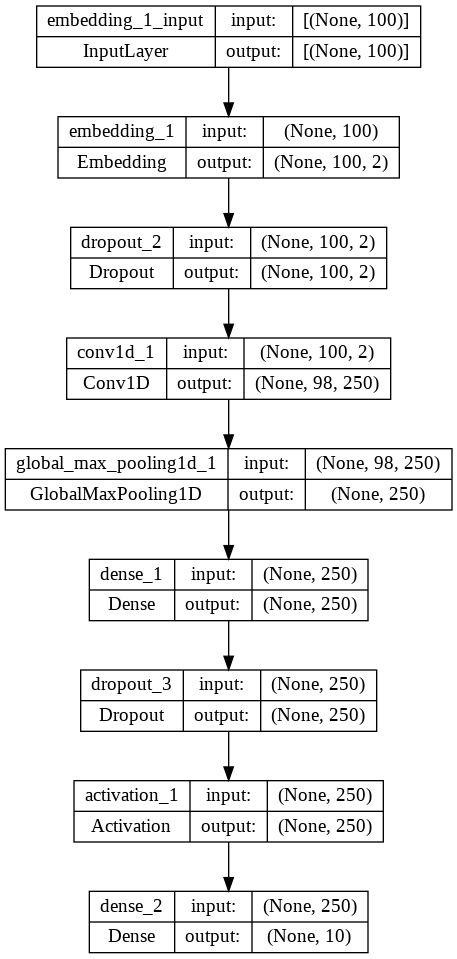

In [ ]:
tf.keras.utils.plot_model(model_cnn,show_shapes=True)

### train model

In [ ]:
history = model_cnn.fit(paded_X_train,y_train,batch_size=16,
      epochs=50,validation_data=(paded_X_test,y_test))

Epoch 1/50
300/300 [==============================] - 11s 4ms/step - loss: 2.0264 - accuracy: 0.2535 - val_loss: 1.5740 - val_accuracy: 0.4183
Epoch 2/50
300/300 [==============================] - 1s 3ms/step - loss: 1.3720 - accuracy: 0.5190 - val_loss: 1.1818 - val_accuracy: 0.5733
Epoch 3/50
300/300 [==============================] - 1s 3ms/step - loss: 0.9978 - accuracy: 0.6777 - val_loss: 0.9933 - val_accuracy: 0.7183
Epoch 4/50
300/300 [==============================] - 1s 3ms/step - loss: 0.7881 - accuracy: 0.7558 - val_loss: 0.9698 - val_accuracy: 0.7167
Epoch 5/50
300/300 [==============================] - 1s 3ms/step - loss: 0.6575 - accuracy: 0.7983 - val_loss: 0.9287 - val_accuracy: 0.7392
Epoch 6/50
300/300 [==============================] - 1s 3ms/step - loss: 0.5701 - accuracy: 0.8183 - val_loss: 1.0144 - val_accuracy: 0.7075
Epoch 7/50
300/300 [==============================] - 1s 3ms/step - loss: 0.5168 - accuracy: 0.8354 - val_loss: 0.9946 - val_accuracy: 0.7258
Epoch

### visualize the result 

### evalute the model

In [ ]:
predict_score = model_cnn.predict(paded_X_test)
predict_label = np.argmax(predict_score,axis=1)
predict_score[:10],predict_label[:10],y_test[:10]

38/38 [==============================] - 0s 2ms/step


(array([[-4.9711113e+00, -8.7231892e-01, -3.8174276e+00, -1.5912697e+00,
         -5.8064322e+00, -2.5084072e-01, -1.5516078e+00,  2.8266478e+00,
          2.5329416e+00, -2.3174880e+00],
        [ 1.3756142e+00, -6.0997772e-01, -3.2004073e+00, -5.7750611e+00,
         -4.1044145e+00, -6.0496225e+00,  5.2135634e-01, -1.1183366e+01,
         -4.5822663e+00,  4.6295710e+00],
        [-6.0301576e+00,  2.3751529e-01, -5.2354980e+00,  4.8543386e+00,
         -2.7197111e+00, -3.5311177e+00, -3.7464707e+00, -5.5050302e+00,
          1.0596199e+00, -1.6404138e+00],
        [ 1.4901102e+00, -1.0581349e+00,  3.2659411e-01, -2.2327285e+00,
         -7.5443971e-01, -1.3561063e+00,  2.4476013e+00, -4.2262206e+00,
         -5.0020318e+00, -1.1550626e+00],
        [-1.2139814e+00, -2.0668824e+00,  4.5324388e-01, -2.5321362e+00,
         -8.7407982e-01, -1.0264802e+00,  2.4297550e+00, -8.2304138e-01,
         -2.3309011e+00, -1.5241162e+00],
        [-5.1022816e+00, -4.8884821e+00, -1.1709957e+01, -4.

array([[ 96,   3,   3,   3,   0,   2,   4,   2,   0,   0],
       [  1, 106,   0,  11,   2,   5,   1,   3,   4,   0],
       [  2,   3,  85,   0,   1,   0,   3,   4,   3,   2],
       [  1,   6,   4,  90,  10,   0,   3,   1,   3,   1],
       [  0,   2,   1,  19,  85,   2,  10,   0,   3,   1],
       [  3,   5,   3,   4,   1,  79,  11,   4,   2,   0],
       [  3,  10,   8,   4,  16,   7,  67,   2,   0,   1],
       [  5,   2,   6,   1,   2,   2,  20,  71,   8,   0],
       [  0,   5,  14,   8,   4,   4,   6,  24,  71,   0],
       [  2,   2,   5,   1,   3,   0,   4,   0,   2, 107]])

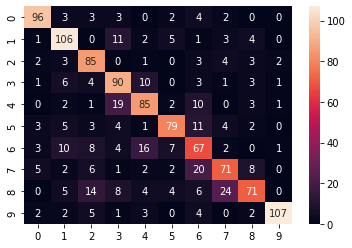

In [ ]:
categories = le.classes_
cf_matrix = confusion_matrix(y_test,predict_label)
sns.heatmap(cf_matrix,annot=True, fmt='g', xticklabels=categories, yticklabels=categories)
cf_matrix

# 2nd LSTM 

## load packages

In [67]:
import pandas as pd
import spacy
import collections
import re
import torch
import torch.nn as nn
import torch.utils.data as data
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

## Dataprocess for 2nd lstm

### def funcs

In [68]:
class WordSequence():
    UNK_TAG = "<UNK>" # unknow word
    PAD_TAG = "<PAD>" # Filler Words
    UNK = 1
    PAD = 0

    def __init__(self):
        self.dict = {
            self.UNK_TAG:self.UNK,
            self.PAD_TAG:self.PAD
        }
        self.count = {}


    def fit(self,sentence):
        '''
        count word sequency
        :param sentence: 
        :return: 
        '''
        for word in sentence:
            self.count[word] = self.count.get(word,0)+1

    def build_vocab(self,min_count=0,max_count = None,max_features = None):
        """
        according to the condition to build the dictionary
        :param min_count: minimal word sequency
        :param max_count: maximal word sequency
        :param max_features: the most number of words
        :return: 
        """
        if min_count is not None:
            self.count = {word:count for word,count in self.count.items() if count >min_count}
        if max_count is not None:
            self.count = {word:count for word,count in self.count.items() if count<max_count}
        if max_features is not None:
            # sort
            self.count = dict(sorted(self.count.items(),lambda x:x[-1],reverse=True)[:max_features])

        for word in self.count:
            self.dict[word] = len(self.dict) # each word correspond a id

        # inverse dictionary
            self.inverse_dict = dict(zip(self.dict.values(),self.dict.keys()))

    def transform(self,sentence,max_len =None):
        '''
        convert sentences to the id sequences
        '''
        if len(sentence) > max_len:
            sentence = sentence[:max_len]
        else:
            sentence = sentence + [self.PAD_TAG]*(max_len-len(sentence))
        return [self.dict.get(i,1) for i in sentence]

    def inverse_transform(self,incides):
        # convert id sequences to the words        
        return [self.inverse_dict.get(i,"<UNK>") for i in incides]

    def __len__(self):
        return len(self.dict)

### define dataset

In [69]:
# define dataset
class MyDataset(data.Dataset):
    def __init__(self, tokens, labels, class_names, word2idx, max_len=41):
        self.tokens = tokens
        self.labels = labels
        self.word2idx = word2idx
        self.max_len = max_len # define a length 
        self.class_names = class_names
        

    def __getitem__(self, index):
        token = self.tokens[index]
        label = self.class_names.index(self.labels[index])
        token = self.word2idx.transform(token, self.max_len)
        token = torch.tensor(token, dtype=torch.long)
        label = torch.tensor(label, dtype=torch.long)
        return token, label

    def __len__(self):
        return len(self.tokens)

### original tokens and labels

In [70]:
with open('drive/MyDrive/tokens.txt', 'rb') as f:
    tokens = eval(f.read())
df = pd.read_csv('drive/MyDrive/paperswithtopic.csv',encoding='utf-8')
labels = df.iloc[:,1:] # get labels 
labels_ = labels.idxmax(axis=1).tolist() # label to list

### get new tokens and labels

In [71]:
labels_counts = {}
for label in labels_:
    if label not in labels_counts.keys():
        labels_counts[label]=1
    else:
        labels_counts[label]+=1

class_names = sorted(labels_counts.items(), key=lambda x: x[1], reverse=True)[2:12]
class_names = [i[0] for i in class_names]
tokens_new = []
labels_new = []
for i in range(len(labels_)):
    if labels_[i] in class_names:
        tokens_new.append(tokens[i])
        labels_new.append(labels_[i])

In [72]:
class_names = list(set(labels_new))
word2idx = WordSequence() 
for token in tokens_new:
    word2idx.fit(token)
word2idx.build_vocab(min_count=0)
# dividing to the train dataset and test dataset

train_tokens, test_tokens, train_labels, test_labels = train_test_split(tokens_new, labels_new, test_size=0.2, random_state=42)

## 2nd LSTM modelling

### customize model

In [73]:
# define model
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers):
        super(Model,self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers,batch_first=True, bidirectional=True, dropout=0.5)
        self.fc = nn.Linear(hidden_dim * 41 *2 , output_dim)

    def forward(self,input):
        input_embeded = self.embedding(input)

        output, (hidden, cell) = self.lstm(input_embeded)
        output = self.fc(output.reshape(output.shape[0], -1))
        
        return  output

### def train lstm2nd

In [74]:
from tqdm import tqdm
def train_lstm2nd(model, device, train_loader, val_loader, epochs, save_path):
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    train_loss, valid_loss  = [], []
    train_acc, valid_acc  = [], []
    correct, correct_val = 0, 0
    total, total_val = 0, 0

    for ep in range(epochs):
        with tqdm(total=len(train_loader), desc=f'Epoch {ep + 1}/{epochs}', unit='it') as pbar:
            for step, batch in enumerate(train_loader):
                model.train()
                inputs, labels = tuple(t.to(device) for t in batch)
                model.zero_grad() #reset gradients 

                output = model(inputs) #get output and hidden states from LSTM network
                loss = loss_fn(output, labels)
                loss.backward()       
                train_loss.append(loss.item())
              
                _, train_pred = torch.max(output, 1)
                
                correct += torch.sum(train_pred==labels).item() #count correctly classified texts per batch
                total += labels.size(0) #count total texts per batch
                train_acc.append(100 * correct / total)

                optimizer.step()

                for step, batch in enumerate(val_loader):

                    with torch.no_grad():

                        model.eval()

                        inputs, labels = tuple(t.to(device) for t in batch)
                        output = model(inputs)
                        val_loss = loss_fn(output, labels)
                        valid_loss.append(val_loss.item())

                        _, val_pred = torch.max(output, 1)

                        correct_val += torch.sum(val_pred==labels).item()
                        total_val += labels.size(0)
                        valid_acc.append(100 * correct_val / total_val)

                pbar.set_postfix(train_loss= format(np.mean(train_loss),'.3f'), 
                            train_acc= format(np.mean(train_acc),'.2f')+'%',
                            val_loss= format(np.mean(valid_loss),'.3f'), 
                            val_acc= format(np.mean(valid_acc),'.2f')+'%',
                            )
                pbar.update(1)
        torch.save(model.state_dict(), save_path)


### define evaluate 2nd lstm

In [81]:
import torch

def evaluate_lstm(model, test_dataloader,save_path, res_file):
    loss_fn = nn.CrossEntropyLoss()
    
    m_state_dict = torch.load(save_path, map_location=device)
    model.to(device)
    model.load_state_dict(m_state_dict)
       
    model.eval()
    test_accuracy = []
    test_loss = []

    with open(res_file, "w", encoding="utf-8") as f:
        for batch in test_dataloader:
            with torch.no_grad():           

                inputs, b_labels = tuple(t.to(device) for t in batch)      
                output = model(inputs)

                loss = loss_fn(output, b_labels)
                test_loss.append(loss.item())
                preds = torch.argmax(output, dim=1).flatten()  

                for idx_max,line in enumerate(output):
                    f.write(str(b_labels[idx_max].item())+" "+str(line[preds[idx_max]].item())+" "+str(preds[idx_max].item())+"\n")
                
                accuracy = (preds == b_labels).cpu().numpy().mean() * 100
                test_accuracy.append(accuracy)

    test_loss = np.mean(test_loss)
    test_accuracy = np.mean(test_accuracy)

    print('test_loss: ', format(test_loss,'.2f'))
    print('test_accuracy: ', format(test_accuracy,'.2f'))

### initate model

In [76]:
import numpy as np
lr = 0.001

embedding_dim = 100
epochs = 10
hidden_dim = 256
n_layers = 4
vocab_size = len(word2idx)

LSTM2nd = Model(vocab_size, embedding_dim, hidden_dim, len(class_names), n_layers)
LSTM2nd.to(device)

Model(
  (embedding): Embedding(14592, 100)
  (lstm): LSTM(100, 256, num_layers=4, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=20992, out_features=10, bias=True)
)

In [77]:
batch_size = 64

# define dataset
train_dataset = MyDataset(train_tokens, train_labels, class_names, word2idx)
val_dataset = MyDataset(test_tokens, test_labels, class_names, word2idx)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

### train 2nd lstm

In [ ]:
train_lstm2nd(LSTM2nd, device, train_loader, val_loader, 3, 'lstm2nd.pt')

# Transformer

## load package

In [ ]:
!pip install matplotlib_inline
!pip install d2l

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import warnings
warnings.filterwarnings('ignore')
import copy
import math
import os
import re
import torch.utils.data
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch
from d2l import torch as d2l
import time

## Dataprocessing for Transformer    -- change path

In [ ]:
class DatasetD(Dataset):
    def __init__(self, data_tensor, target_tensor):
        self.data_tensor = data_tensor
        self.target_tensor = target_tensor


    def __len__(self):
        return len(self.data_tensor)

    def __getitem__(self, index):
        return self.data_tensor[index], self.target_tensor[index]

In [ ]:
import pandas as pd
import os
import numpy as np


def pre_processing(route):
  df = pd.read_csv(route)

  df1 = df.loc[:, 'adversarial':'time-series'].idxmax(axis=1)
  df['result'] = df1

  result_df = df[["Unnamed: 0", "result"]].rename({"Unnamed: 0": "comment"}, axis=1)
  
  titles = ["adversarial", "computer-code", "computer-vision", "graphs", "knowledge-base",
              "miscellaneous", "natural-language-processing", "playing-games",
              "robots", "speech"]
  for title in titles:
      df1 = result_df[result_df['result'] == title ][['comment']]
      os.makedirs('drive/MyDrive/result', exist_ok=True)
      df1.to_csv(f"drive/MyDrive/result/{title}.csv", index=False) 

In [ ]:
!pip install --upgrade pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.3 MB 4.7 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.2.4
    Uninstalling pandas-1.2.4:
      Successfully uninstalled pandas-1.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
d2l 0.17.6 requires pandas==1.2.4, but you have pandas 1.3.5 which is incompatible.


In [ ]:
pre_processing("drive/MyDrive/paperswithtopic.csv")

In [ ]:
for subdir in os.listdir("drive/MyDrive/result/"):
    print(subdir)

adversarial.csv
computer-code.csv
computer-vision.csv
graphs.csv
knowledge-base.csv
miscellaneous.csv
natural-language-processing.csv
playing-games.csv
robots.csv
speech.csv


In [ ]:
path="drive/MyDrive/result/"
index=0
maxlen=0
indexOfword=[]
indexOfword2=0
listofword=[]
feature=[]
label=[]
# reading the dataset
for subdir in os.listdir(path):
    print(subdir)
    with open('drive/MyDrive/result/'+subdir, 'r',encoding='utf-8') as f:
        file = f.read()
        file=file.lower()
        file=file[8:]

        if not bool(re.search('[a-z]',file[-1])):
            file=file[:-1]

        file2=copy.deepcopy(file)
        file2=list(file2)

        for i in range(len(file)):
            if not bool(re.search('[a-z]', file[i])) and file[i]!=' ' and file[i]!='\n':
                file2[i]=' '

        file2=''.join(file2)
        file2 = file2.split('\n')
        file=[]
        for i in range(len(file2)):
            file2[i]=file2[i].split(' ')

        for i in range(len(file2)):
            temp=[]
            for j in range(len(file2[i])):
                if not bool(re.search('[a-z]', file2[i][j])):
                    continue
                else:
                    temp.append(file2[i][j])
            file.append(temp)

        for i in range(len(file)):
            for j in range(len(file[i])):
                if file[i][j] not in listofword:
                    listofword.append(file[i][j])
                    indexOfword.append(indexOfword2)
                    indexOfword2+=1

        file=file[:600]

        for i in range(len(file)):
            temp=[]
            for j in range(len(file[i])):
                temp.append(listofword.index(file[i][j]))
            feature.append(temp)
            if len(temp)>maxlen:
                maxlen=len(temp)
            if index == 0:
                label.append(torch.tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))
            elif index == 1:
                label.append(torch.tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))
            elif index == 2:
                label.append(torch.tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))
            elif index == 3:
                label.append(torch.tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))
            elif index == 4:
                label.append(torch.tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]))
            elif index == 5:
                label.append(torch.tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]))
            elif index == 6:
                label.append(torch.tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]))
            elif index == 7:
                label.append(torch.tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]))
            elif index == 8:
                label.append(torch.tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]))
            elif index == 9:
                label.append(torch.tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]))

    index += 1


for i in range(len(feature)):
    if len(feature[i])<maxlen:
        for j in range(0,(maxlen-len(feature[i]))):
            feature[i].append(0)
    feature[i]=torch.tensor(feature[i])

feature=torch.stack(feature,0)
label=torch.stack(label,0)


train_dataset=DatasetD(feature,label)
train_loader=DataLoader(train_dataset,batch_size=64,shuffle=True)


adversarial.csv
computer-code.csv
computer-vision.csv
graphs.csv
knowledge-base.csv
miscellaneous.csv
natural-language-processing.csv
playing-games.csv
robots.csv
speech.csv


## define func of encoder

In [ ]:
# full connection layer
class ffn(nn.Module):
    def __init__(self, num_input, num_hiddens, num_output, **kwargs):
        super(ffn, self).__init__(**kwargs)
        self.dense1 = nn.Linear(num_input, num_hiddens)
        self.relu = nn.ReLU()
        #
        self.dense2 = nn.Linear(num_hiddens, num_output)

    def forward(self, x):
        return self.dense2(self.relu(self.dense1(x)))


# Residual network and layerNorm. Reference from resnet and layernormalization
class AddNorm(nn.Module):
    def __init__(self, normalized_shape, drop, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.drop = nn.Dropout(drop)
        self.ln = nn.LayerNorm(normalized_shape)

    def forward(self, input, output_to_addnorm):
        output = self.drop(output_to_addnorm) + input
        output = self.ln(output)
        return output
    
# multihead attention, referencing paper of Attention of all you need.
class MultiHeadAttention(nn.Module):
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 num_heads, dropout, bias=False, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        # There are two attention score,AdditiveAttention and DotProductAttention
        # using AdditiveAttention in this assignment
        self.attention = d2l.AdditiveAttention(num_hiddens, num_hiddens, num_hiddens, dropout)
        # self.attention = d2l.DotProductAttention(dropout)

        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        if valid_lens is not None:
            valid_lens = torch.repeat_interleave(valid_lens,
                                                 repeats=self.num_heads,
                                                 dim=0)
        # if using DotProductAttention(dropout), will using this function below.
        # queries = self.transform_qkv(self.W_q(queries), self.num_heads)
        # keys = self.transform_qkv(self.W_k(keys), self.num_heads)
        # values = self.transform_qkv(self.W_v(values), self.num_heads)
        output = self.attention(queries, keys, values, valid_lens)

        # output_concat = self.transform_output(output, self.num_heads)
        # return self.W_o(output_concat)
        return output

    
# using learnable embedding
class Embedding(nn.Module):
    def __init__(self,vocab_size,d_model):
        super(Embedding, self).__init__()
        self.tok_embed = nn.Embedding(vocab_size, d_model)  # token embedding
        self.pos_embed = nn.Embedding(maxlen, d_model)  # position embedding
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x):
        # take the max length of sentence
        seq_len = x.size(1)
        # creating the matrix with zeros
        pos = torch.arange(seq_len, dtype=torch.long)
        pos = pos.unsqueeze(0).expand_as(x)  # [seq_len] -> [batch_size, seq_len]
        # learnable embedding
        embedding = self.tok_embed(x) + self.pos_embed(pos)
        return self.norm(embedding)

## def encoder

In [ ]:
class Encoderlayer(nn.Module):
    def __init__(self, s_key, s_q, s_v, num_hidden, norm_shape,
                 ffn_input_size, ffn_hidden_size, num_head, drop, bias=False, **kwargs):
        super(Encoderlayer, self).__init__(**kwargs)
        self.attention = MultiHeadAttention(s_key, s_q, s_v, num_hidden, num_head, drop, bias)
        self.fistaddnorn = AddNorm(norm_shape, drop)
        self.ffn = ffn(ffn_input_size, ffn_hidden_size, num_hidden)
        self.secondaddnorn = AddNorm(norm_shape, drop)
        self.Linear=nn.Linear(num_hidden,num_hidden)
        self.active=nn.Tanh()

    def forward(self, x, valid_len):
        Y=self.fistaddnorn(x,self.attention(x,x,x,valid_len))
        Y=self.secondaddnorn(Y,self.ffn(Y))
        ly=self.Linear(Y)
        # a short cut, like the resnet
        return self.active(ly+Y)

In [ ]:
# Encoder
class Encoder(d2l.Encoder):
    def __init__(self, vocab_size, s_k, s_q, s_v, num_hidden,
                 norm_shape, ffn_input, ffn_hidden, num_heads, num_layers, drop, bias=False, **kwargs):
        super(Encoder, self).__init__(**kwargs)
        self.num_hidden = num_hidden
        # embedding every word
        self.embedding = Embedding(vocab_size,num_hidden)
        # add Positionan information in every word
        self.position_encoding = d2l.PositionalEncoding(num_hidden, drop)
        self.layers = nn.Sequential()
        for i in range(num_layers):
            self.layers.add_module('layer' + str(i),
                                   Encoderlayer(s_k, s_q, s_v, num_hidden, norm_shape,
                                                ffn_input, ffn_hidden, num_heads, drop, bias))

    def forward(self, x,value_len, *args):
        x=self.position_encoding(self.embedding(x) * math.sqrt(self.num_hidden))
        for i, layer in enumerate(self.layers):
            x = layer(x, value_len)
        return x

In [ ]:
class MiniEncoder(nn.Module):
    def __init__(self,outputsize,vocab_size, s_k, s_q, s_v, num_hidden,
                 norm_shape, ffn_input, ffn_hidden, num_heads, num_layers, drop, bias=False, **kwargs):
        super(MiniEncoder, self).__init__(**kwargs)
        # Encoderlayer
        self.encoder_layer = Encoderlayer(s_k, s_q, s_v, num_hidden, norm_shape,
                 ffn_input, ffn_hidden, num_heads, drop, bias)
        # Encoder, including Encoderlayers
        self.transformer_encoder = Encoder(vocab_size, s_k, s_q, s_v, num_hidden,
                 norm_shape, ffn_input, ffn_hidden, num_heads, num_layers, drop, bias)
        # two linear layer
        self.linear=nn.Linear(ffn_hidden*maxlen,200)
        self.lastLiner=nn.Linear(200,outputsize)
        # activite function
        self.tanh=nn.Tanh()
        # sofmax
        self.softmax = nn.Softmax(dim=-1)
    def forward(self,input,valid_len):
        output=self.transformer_encoder(input,valid_len)
        output=output.reshape((output.shape[0],-1))
        result=self.linear(output)
        result = self.tanh(result)
        result=self.lastLiner(result)
        result=self.tanh(result)
        result = self.softmax(result)
        return result

## initate model

In [ ]:
num_hiddens, num_layers, dropout, batch_size = 64, 8, 0.1, 64
ffn_input, ffn_hiddens, num_heads = 64, 64, 4
key_size, query_size, value_size = 64, 64, 64
norm_shape = [64]
net=MiniEncoder(index,len(listofword),key_size, query_size, value_size
                             , num_hiddens, norm_shape, ffn_input, ffn_hiddens, num_heads, num_layers, dropout)


## def train Tranformer

In [ ]:
# recall_score
from sklearn.metrics import recall_score
# f1,f2 score
from sklearn.metrics import fbeta_score
# training
def train(net, train_loader, optimizer):
    total=0
    correct=0
    recall=0
    batch_num=0
    f1=0
    f2=0

    for batch_id, (data,target) in enumerate(train_loader):
        optimizer.zero_grad()  # zero the gradients
        output = net(data,None)       # apply network
        loss = F.cross_entropy(output,target)
        loss.backward()          # compute gradients
        optimizer.step()         # update weights
        outputindex=output.argmax(dim=-1)
        predicindex=target.argmax(dim=-1)
        correct += (outputindex == predicindex).float().sum()
        total += target.size()[0]
        for i in range(len(outputindex)):
            output[i]=torch.tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
            output[i][outputindex[i]]=1
        recall += recall_score(output.detach().numpy(), target.detach().numpy(), average='macro')
        f1 += fbeta_score(output.detach().numpy(), target.detach().numpy(), beta=1, average='macro')
        f2 += fbeta_score(output.detach().numpy(), target.detach().numpy(), beta=10, average='macro')

        batch_num+=1

    avgaccuracy=correct/total
    recall=recall/batch_num
    f1=f1/batch_num
    f2 = f2 / batch_num

    return avgaccuracy,recall,f1,f2


## train model

epoch 1
accuracy: 0.442592591047287
recall: 0.46509091287205595
f1 score: 0.41964376321556984
f2 score: 0.46272857128797357
epoch 2
accuracy: 0.4453703761100769
recall: 0.4717358925459089
f1 score: 0.42292571684191177
f2 score: 0.46936418358994414
epoch 3
accuracy: 0.4601851999759674
recall: 0.47602624328845283
f1 score: 0.42958158431367544
f2 score: 0.4734340576679277
epoch 4
accuracy: 0.45092591643333435
recall: 0.4693290657324478
f1 score: 0.4229644829200247
f2 score: 0.46697742087616245
epoch 5
accuracy: 0.4651851952075958
recall: 0.4933611195464186
f1 score: 0.43493155653289933
f2 score: 0.49044203627124017
epoch 6
accuracy: 0.4627777636051178
recall: 0.4858072164714196
f1 score: 0.43402150704840786
f2 score: 0.48320591054675255
epoch 7
accuracy: 0.4801851809024811
recall: 0.5196126979474944
f1 score: 0.4544905260622273
f2 score: 0.5163027449932943
epoch 8
accuracy: 0.47777777910232544
recall: 0.49492475653705087
f1 score: 0.4420023753798394
f2 score: 0.4919720055667487
epoch 9
ac

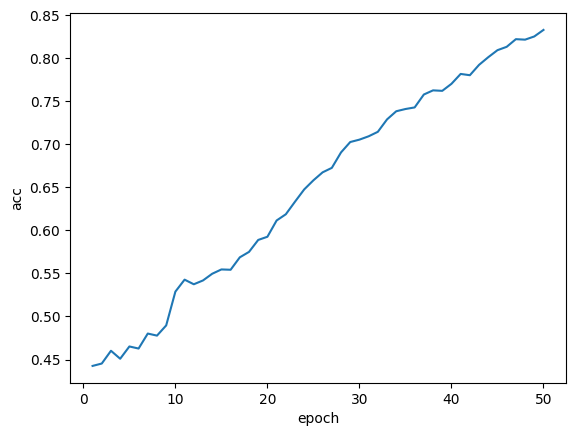

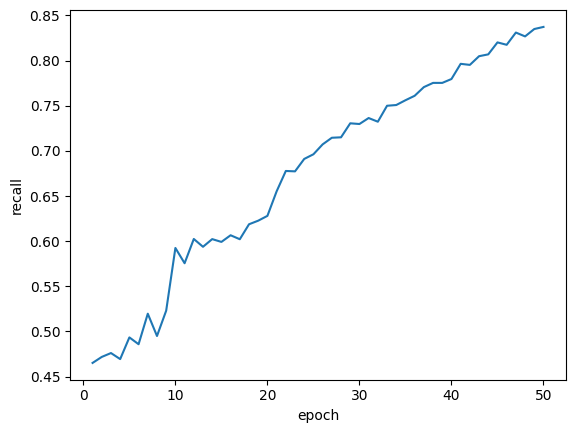

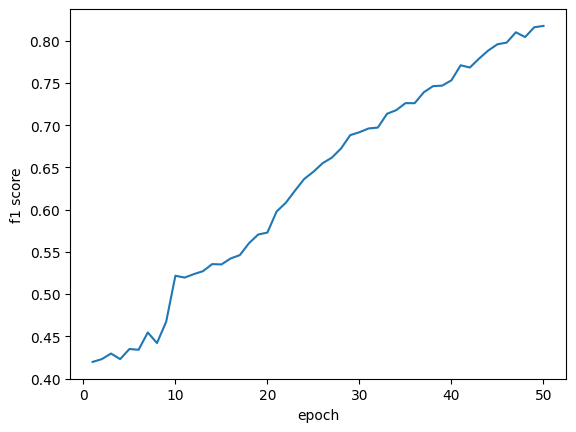

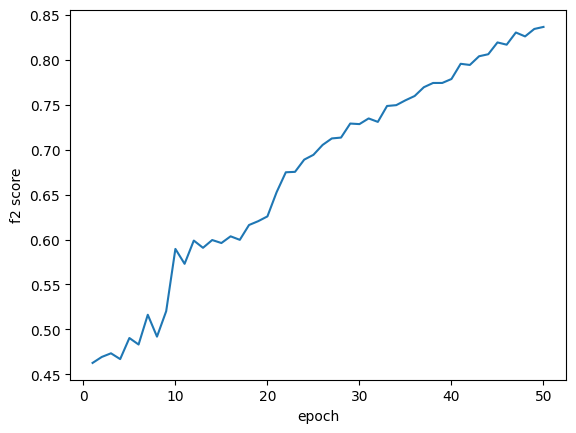

In [ ]:
optimizer = torch.optim.Adam(net.parameters(),lr=0.001,
                             weight_decay=0.001)

epoch = 0
accl=[]
rel=[]
f1l=[]
f2l=[]
index=0
xg=[]
while epoch < 50:
    epoch = epoch+1
    index +=1
    avgaccuracy,recall,f1,f2 = train(net, train_loader, optimizer)
    print('epoch {}'.format(epoch))
    print('accuracy: {}'.format(avgaccuracy))
    print('recall: {}'.format(recall))
    print('f1 score: {}'.format(f1))
    print('f2 score: {}'.format(f2))
    accl.append(avgaccuracy)
    rel.append(recall)
    f1l.append(f1)
    f2l.append(f2)
    xg.append(index)

plt.xlabel('epoch')
plt.ylabel('acc')
plt.plot(xg,accl)
plt.show()

plt.xlabel('epoch')
plt.ylabel('recall')
plt.plot(xg,rel)
plt.show()

plt.xlabel('epoch')
plt.ylabel('f1 score')
plt.plot(xg,f1l)
plt.show()

plt.xlabel('epoch')
plt.ylabel('f2 score')
plt.plot(xg,f2l)
plt.show()

# Result comparison

### evaluate bert

In [39]:
evaluate_bert(bertV1, test_dataloader,'drive/MyDrive/bertV1_a.pt', 'res_bertV1_a.txt')

test_loss:  1.45
test_accuracy:  77.71


In [40]:
evaluate_bert(bertV1, test_dataloader,'drive/MyDrive/bertV1_b.pt', 'res_bertV1_b.txt')

test_loss:  1.06
test_accuracy:  87.34


In [42]:
evaluate_bert(bertV2, test_dataloader,'drive/MyDrive/bertV2_a.pt', 'res_bertV2_a.txt')

test_loss:  1.35
test_accuracy:  77.55


In [43]:
evaluate_bert(bertV2, test_dataloader,'drive/MyDrive/bertV2_b.pt', 'res_bertV2_b.txt')

test_loss:  0.99
test_accuracy:  87.50


classification report：
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       120
           1       0.88      0.96      0.92       120
           2       0.87      0.96      0.91       120
           3       0.84      0.90      0.87       120
           4       0.83      0.88      0.86       120
           5       0.95      0.89      0.92       120
           6       0.73      0.64      0.68       120
           7       0.91      0.94      0.93       120
           8       0.84      0.85      0.84       120
           9       0.95      0.75      0.84       120

    accuracy                           0.88      1200
   macro avg       0.88      0.88      0.87      1200
weighted avg       0.88      0.88      0.87      1200



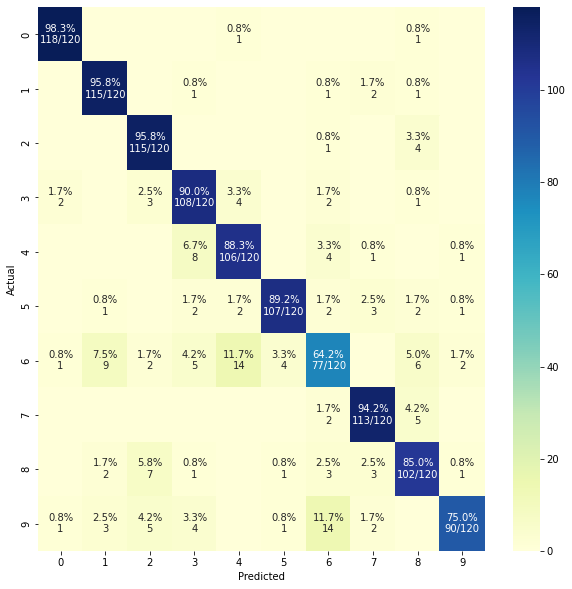

In [45]:
get_eval('res_bertV2_b.txt')

- https://github.com/rguthrie3/DeepLearningForNLPInPytorch/blob/master/Deep%20Learning%20for%20Natural%20Language%20Processing%20with%20Pytorch.ipynb
- https://www.kaggle.com/code/ludovicocuoghi/detecting-bullying-tweets-pytorch-lstm-bert
- https://www.kaggle.com/code/swarnabha/pytorch-text-classification-torchtext-lstm


### evaluate lstm

In [ ]:
evaluate_lstm(LSTM_V1, test_loader,'lstmV1.pt', 'res_lstmV1.txt')

test_loss:  1.95
test_accuracy:  73.06


classification report：
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       119
           1       0.75      0.82      0.78       119
           2       0.72      0.69      0.70       118
           3       0.74      0.73      0.74       120
           4       0.73      0.71      0.72       116
           5       0.81      0.75      0.78       119
           6       0.57      0.59      0.58       119
           7       0.75      0.77      0.76       118
           8       0.67      0.64      0.66       120
           9       0.73      0.75      0.74       116

    accuracy                           0.73      1184
   macro avg       0.73      0.73      0.73      1184
weighted avg       0.73      0.73      0.73      1184



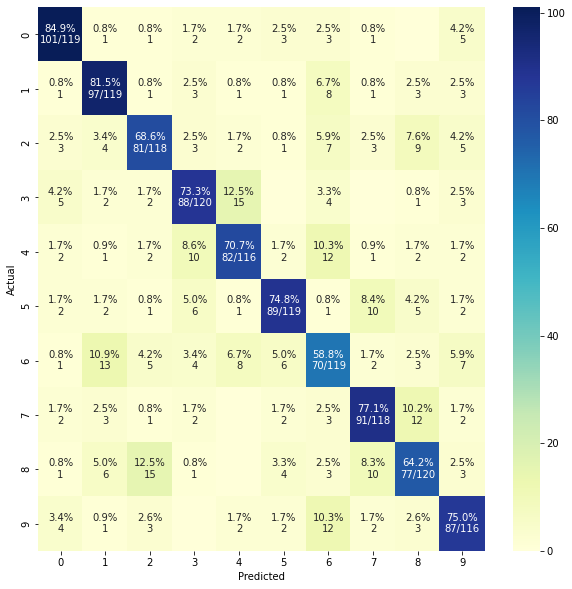

In [ ]:
get_eval('res_lstmV1.txt')

### evaluate CNN

In [ ]:
model_cnn.evaluate(paded_X_test,y_test)

38/38 [==============================] - 0s 2ms/step - loss: 1.3448 - accuracy: 0.7142


[1.3447526693344116, 0.7141666412353516]

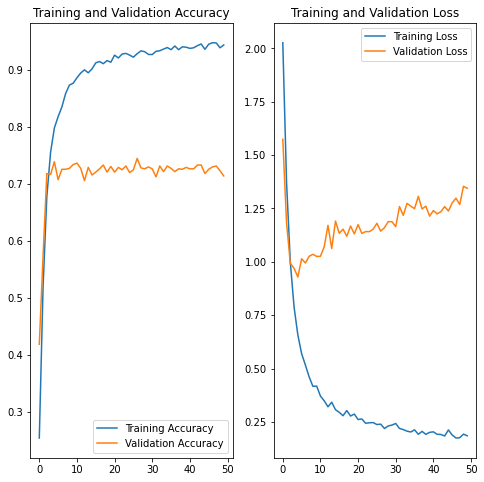

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = 50
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### evaluate 2nd lstm

In [84]:
evaluate_lstm(LSTM2nd, val_loader,'lstm2nd.pt', 'res_lstm2nd.txt')

test_loss:  2.51
test_accuracy:  66.04


classification report：
              precision    recall  f1-score   support

           0       0.78      0.49      0.61       287
           1       0.70      0.86      0.77       719
           2       0.57      0.49      0.53       331
           3       0.87      0.77      0.82       624
           4       0.65      0.69      0.67       806
           5       0.75      0.80      0.77       700
           6       0.67      0.58      0.62       158
           7       0.48      0.55      0.51       725
           8       0.61      0.48      0.54       259
           9       0.90      0.70      0.79       255

    accuracy                           0.68      4864
   macro avg       0.70      0.64      0.66      4864
weighted avg       0.69      0.68      0.68      4864



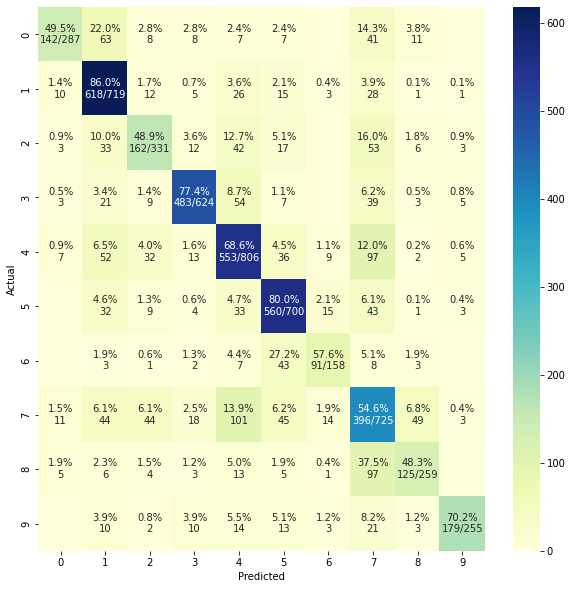

In [ ]:
get_eval('res_lstm2nd.txt')

# Discussion

## step1

After applying basic data cleaning and preprocessing to the dataset, we got data_version1.

We use data_verson1 on LSTM2nd, CNN, self_created modle and LSTM_v1.

Result:

LSTM2nd: 66.04%

CNN: 71.42%

self_created model: 83.27%

LSTM_v1: 73.06%


## step2: fine-tuning on bert

we improve the dataset and get data_verson2, which is applied to bert again.

Result: 

bert1: 77.71%

bert2: 77.55%

## step3: improvement on dataset
bert1:87.34%  

bert2:87.50%

## step4: applied all the improvements to LSTM

LSTMv1:73.06%

## conclusion
In this project, we did 9 model-trainings using different models on different datasets (discussed below). For all the training, we use 10 labels and run 30 epochs. 

In step 1, after applying basic data cleaning and preprocessing to the dataset, we got data_version1. We use data_verson1 on LSTM_1, CNN, self-created model, LSTM_2, and Bert. The best performance models are LSTM2 and BERT. 

In step 2, we did more fine-tuning to Bert model, including norm layer and pooling layer. We got the result of 77.55%.  

In step 3, we investigate the dataset again and drop the titles with 2 labels in the dataset. We applied this data_version2 to the Bert model and improved Bert model and there is significant improvement on the accuracy (87.34% and 87.50%). 

In step 4, we applied LSTM2 with improved fine-tuning (discussed in step2) to the data_version2 and got the result of 73.06%. 

The results of the two LSTMs show that data processing has a significant impact on the model. The finer the data processing, the smaller the difference in data volume between the various types of labels, the better the training effect of the model. For multi-label data, the larger data volume does not significantly improve the training results; what is important is the classification average of the data. 

 

Aside from what we discussed above, we also decreased the learning rate to avoid overfitting and adjust the dropout value. We tried to freeze Bert pre-trained parameters, but this would decrease the training accuracy significantly. 

In summary, although the highest accuracy is 87.50% from Bert model, but Bert model is time-consuming because we didn’t freeze the pre-trained parameters. There is a tradeoff between training efficiency and accuracy. Also, the performance improvement is not significant after applying more fine-tuning on Bert models. In the future, we can do more research on how to do fine-tuning on pre-trained models so that the performance can be improved significantly. 